## Mercari Price Suggestion

### Import statements

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

import timeit

In [3]:
PATH='data/'
!ls {PATH}

models	sample_submission.csv  test.tsv  tmp  train.tsv


In [4]:
train = pd.read_csv(f'{PATH}/train.tsv', sep='\t')
test_df = pd.read_csv(f'{PATH}/test.tsv', sep='\t')

In [5]:
display(train.head(2))
display(test_df.head(2))

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."


In [6]:
def join_columns(df):
    # casting into string converts NaN to nan
    ret = '<category> ' + df.category_name.astype(str).str.replace(r'[\s*]','').str.replace(r'/',' ') 
    ret += ' <name> ' + df.name.astype(str) + ' <description> ' + df.item_description.astype(str)
    return ret

train['item_description'] = join_columns(train)
test_df['item_description'] = join_columns(test_df)

In [7]:
train['item_description'].iloc[0]

'<category> Men Tops T-shirts <name> MLB Cincinnati Reds T Shirt Size XL <description> No description yet'

In [8]:
ntrn = len(train)
ntrn

1482535

In [9]:
val_idx = train.sample(int(ntrn*0.2)).index
(val_df, train_df),  = split_by_idx(val_idx, train)

In [10]:
len(val_df)/ntrn

0.2

## Tokenization

In [11]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
re_ptbl = re.compile(f'([{string.printable}])')
re_rm = re.compile(r'\s*\[\s*rm\s*\]\s*')
re_num = re.compile(r'([0-9])')

In [12]:
import collections
all_des = val_df['item_description'].str.cat(sep=' ')
chars = list(all_des)
counter=collections.Counter(chars)
ret = str('')
for x in counter: ret += x[0]
ret

'<category> HmDéAnsLhSudipNw.Rlf[]bTqkFJW24KGOC&7Yz/x!)B-~:v✨“”,1MEVX50\'6PI3U8%(+9"\xa0Q@*#;Z➡♡j•❤️\u3000?［］＊–è’|$⚡▪❄…®✴{}\\❇=☑Ó‼☆♥_⬇❗⛔♦°⭐¡^üë❣✭íÁ½✳×✅❌—☺✔➖《》¤″⚠⬆➕■☇◇●▶➔！✉☀✖á★✧ツ†〰\u200b€¥É©™\u2028ñシ、（），：‘ú❎☄ô◀ᏢᎡᏟᏞᎬᎪᎢᏌᏚᏆ·♨⚜⃣▼�√«»\xad⁉α£︎❥♏✈▫⬅ē❓å➺Õ¼☞✽♢○âÜÍᏩᏙᎾᎠᏔç♧◡̈⭕ō⚫ᔕᖇᒪᑎᐯᖴᗩᗯ‑Ⓜ☼⤵↪Ω`⇻◈①②③❀\u2029⏺\x7fΚΑθ⋆ғʀᴇʜɪᴘʟᴛᴏᴀᴋɴʏǫᴜᴍᴠʙᴄᴅɢᴡッ¾ℹ◕‿╹⊙︿⏩⏪✝□℃ä✏いなばぁっこんにちはたらラタンワとゃ日本の中古品です。オリジナルケース付きませう傷があり自宅再生機視聴可能しよろくお願ᎷᏴᎻ❁⇝↓⛵【】◑┅♠\u200eĒ→☻´∀｀・Ñ♻Ô⏰óØᐠᐛᐟ❕⛥¹ᑕᗰ◉ı↖↘↙；ᕼᗷᑌᗪ✓∆ì►⚘ºʕᴥʔà✌ω～✦➾➳⚀✩ꕥ✿ß❃☾☽⚾È▵ÄÇ⚅◆█✯û♛≥≤Ⓡ♤ᴢ◾◼乛Öū⟁➜☡✲゜͡ᵔ͜ʖ☕✂³⚪čï※➰\x96\x16ᴊ↔÷ă✪˘¦îê◠✬Β✘語⁄Ìღ✮？＆☐ø⛤☝\uf8e7ꪹꪵ\uf81e\uf823\uf8eaℓєя⊝◦☃❊⠀ö²―⌚Σ￣\uf8ff➙⚓Ꮓ↩¿☯☮⚛☪\ufeff͈ᴗ☒⅜〽ⓡⓔⓓⓑⓛⓐⓒⓚⓦⓗⓘⓣⓢⓤⓝ§Δξェヽノ✕➝∅ⓟⓜⓞⓕ☜↟◄⇒Â═☔❶❷❸❹❺❻،¶Æ˚⛅ﬁ\x99♪⇢⋅¢༶⛄☠＼／ʘ＄☸⚃「」☹➀➁⛳‡ËŸŠ℅⅛ㅡ⟹❦☁Ûś『』šù✷⊹õã⺣\u202f⬛İ⏹Ⓢⓨ±⚁￼⅔✄ŕ▿ò➪⁰ā୨୧\x95∙̀\u2009♫⛱❔ᑭ➵☘⇨⇦➲\uf84c△♀℉˝✼さ冊¯ọ✫Ð↕\uf8ba\uf8bc\uf8b8\uf8bd\uf8b9\uf8c0⌛国结刺绣小紫色的心形丝绸挂件Ū\x14⁴♣⛓〜ゝ∂㎡᙭′どかも森絵ポトビ他╮╯╰╭Φ\x92➿⏬招猫一'

In [13]:
# to skip computation
ret = """HmDéAnsLhSudipNw.Rlf[]bTqkFJW24KGOC&7Yz/x!)B-~:v✨“”,1MEVX50\'6PI3U8%(+9"\xa0Q@*#;Z➡♡j•❤️\u3000?［］＊–è’|$⚡▪❄…®✴{}\\❇=☑Ó‼☆♥_⬇❗⛔♦°⭐¡^üë❣✭íÁ½✳×✅❌—☺✔➖《》¤″⚠⬆➕■☇◇●▶➔！✉☀✖á★✧ツ†〰\u200b€¥É©™\u2028ñシ、（），：‘ú❎☄ô◀ᏢᎡᏟᏞᎬᎪᎢᏌᏚᏆ·♨⚜⃣▼�√«»\xad⁉α£︎❥♏✈▫⬅ē❓å➺Õ¼☞✽♢○âÜÍᏩᏙᎾᎠᏔç♧◡̈⭕ō⚫ᔕᖇᒪᑎᐯᖴᗩᗯ‑Ⓜ☼⤵↪Ω`⇻◈①②③❀\u2029⏺\x7fΚΑθ⋆ғʀᴇʜɪᴘʟᴛᴏᴀᴋɴʏǫᴜᴍᴠʙᴄᴅɢᴡッ¾ℹ◕‿╹⊙︿⏩⏪✝□℃ä✏いなばぁっこんにちはたらラタンワとゃ日本の中古品です。オリジナルケース付きませう傷があり自宅再生機視聴可能しよろくお願ᎷᏴᎻ❁⇝↓⛵【】◑┅♠\u200eĒ→☻´∀｀・Ñ♻Ô⏰óØᐠᐛᐟ❕⛥¹ᑕᗰ◉ı↖↘↙；ᕼᗷᑌᗪ✓∆ì►⚘ºʕᴥʔà✌ω～✦➾➳⚀✩ꕥ✿ß❃☾☽⚾È▵ÄÇ⚅◆█✯û♛≥≤Ⓡ♤ᴢ◾◼乛Öū⟁➜☡✲゜͡ᵔ͜ʖ☕✂³⚪čï※➰\x96\x16ᴊ↔÷ă✪˘¦îê◠✬Β✘語⁄Ìღ✮？＆☐ø⛤☝\uf8e7ꪹꪵ\uf81e\uf823\uf8eaℓєя⊝◦☃❊⠀ö²―⌚Σ￣\uf8ff➙⚓Ꮓ↩¿☯☮⚛☪\ufeff͈ᴗ☒⅜〽ⓡⓔⓓⓑⓛⓐⓒⓚⓦⓗⓘⓣⓢⓤⓝ§Δξェヽノ✕➝∅ⓟⓜⓞⓕ☜↟◄⇒Â═☔❶❷❸❹❺❻،¶Æ˚⛅ﬁ\x99♪⇢⋅¢༶⛄☠＼／ʘ＄☸⚃「」☹➀➁⛳‡ËŸŠ℅⅛ㅡ⟹❦☁Ûś『』šù✷⊹õã⺣\u202f⬛İ⏹Ⓢⓨ±⚁￼⅔✄ŕ▿ò➪⁰ā୨୧\x95∙̀\u2009♫⛱❔ᑭ➵☘⇨⇦➲\uf84c△♀℉˝✼さ冊¯ọ✫Ð↕\uf8ba\uf8bc\uf8b8\uf8bd\uf8b9\uf8c0⌛国结刺绣小紫色的心形丝绸挂件Ū\x14⁴♣⛓〜ゝ∂㎡᙭′どかも森絵ポトビ他╮╯╰╭Φ\x92➿⏬招猫一"""

In [14]:
spcl = re_ptbl.sub(r'', ret)
re_spcl = re.compile(f'([{spcl}])')

In [15]:
from spacy.symbols import ORTH

my_tok = spacy.load('en')

# To join multiple columns
# my_tok.tokenizer.add_special_case('<SUMM>', [{ORTH: '<SUMM>'}])
my_tok.tokenizer.add_special_case('<eos>', [{ORTH: '<eos>'}])
my_tok.tokenizer.add_special_case('<category>', [{ORTH: '<category>'}])
my_tok.tokenizer.add_special_case('<name>', [{ORTH: '<name>'}])
my_tok.tokenizer.add_special_case('<description>', [{ORTH: '<description>'}])
my_tok.tokenizer.add_special_case('[rm]', [{ORTH: '[rm]'}])

def my_spacy_tok(x):
    x = str(x).lower()
    # x = re.sub(r'[^\x00-\x7f]', r' ', x)
    x = re_rm.sub(' [rm] ', x)
    x = re_num.sub(r' \1 ', x)
    x = re_spcl.sub(r' \1 ', x)
    x = ' '.join(x.split())
    return [tok.text for tok in my_tok.tokenizer(x)]

## Language Model for category, name and item_description 

In [16]:
# Use small portion for text modeling 
sample = 0.2
train_text = train.sample(int(sample*len(train))).reset_index()

In [17]:
text_val_idx = train_text.sample(int(len(train_text)*0.2)).index
(val_text, train_text),  = split_by_idx(text_val_idx, train_text)

(array([   1135.,   56803.,  111234.,  172722.,  100045.,  138350.,   83271.,  109401.,   63493.,   81542.,
          46619.,   61350.,   35199.,   45828.,   27106.,   36000.,   21148.,   27510.,   16214.,   21298.,
        ...,     162.,      88.,     200.,      82.,      47.,      96.,     101.,      32.,      79.,
             24.,       8.,       1.,       2.,       0.,       1.,       0.,       1.,       1.,       1.,
              1.]),
 array([   6.  ,    8.52,   11.04,   13.56,   16.08,   18.6 ,   21.12,   23.64,   26.16,   28.68,   31.2 ,
          33.72,   36.24,   38.76,   41.28,   43.8 ,   46.32,   48.84,   51.36,   53.88, ...,  210.12,  212.64,
         215.16,  217.68,  220.2 ,  222.72,  225.24,  227.76,  230.28,  232.8 ,  235.32,  237.84,  240.36,
         242.88,  245.4 ,  247.92,  250.44,  252.96,  255.48,  258.  ]),
 <a list of 100 Patch objects>)

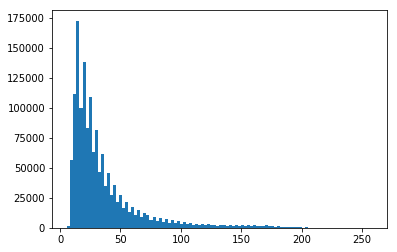

In [18]:
text_length = train['item_description'].apply(lambda x: len(str(x).split()))
plt.hist(text_length, bins=100)

In [19]:
ITEM_DESCRIPTION = data.Field(lower=True, tokenize=my_spacy_tok)

Possible text processings:
0. min_freq, bs, bptt 
1. highlight for a streak of caps
2. replace " -" word with `<list>`
3. plural handling (?)
4. handling past/present/future tense


In [20]:
bs,bptt = 128,50
min_freq=10

In [21]:
# DF takes 12mins on GTX1060
idmd = LanguageModelData.from_dataframes(PATH, ITEM_DESCRIPTION, 'item_description', train_text, val_text, val_text, 
                                       bs=bs, bptt=bptt, min_freq=min_freq)
pickle.dump(ITEM_DESCRIPTION, open(f'{PATH}models/ITEM_DESCRIPTION_{min_freq}.pkl','wb'))

In [22]:
# This is to test if numericalization is possible with the given text with symbols and all special characters
# Since the origibal text can be lengthy 
def test_text_dataload(df, col):
    # fir create Fields
    TEXT = data.Field(lower=True, tokenize=my_spacy_tok)
    fields = [('text', TEXT)]
    text = []
    # Tokenize
    text += TEXT.preprocess(df[col].str.cat(sep=' <eos> '))
    text.append('<eos>')
    # create datasets
    examples = [torchtext.data.Example.fromlist([text], fields)]
    dataset = torchtext.data.Dataset(examples, fields)
    # create dataloader from dataset this is one long text 
    text = sum([o.text for o in dataset], [])
    n=100
    for i in np.arange(int(len(text)/n)):
        itext = [text[i*n:(i+1)*n]]
        try: 
            nums = TEXT.numericalize(itext)
        except (RuntimeError):
            print(itext)
    return 

#test_numericalize(train_text, 'item_description')

In [23]:
idxs = ITEM_DESCRIPTION.numericalize([['♥', 'xyz']])
idxs = idxs.data.cpu().numpy().ravel()
#ITEM_DESCRIPTION.vocab.itos[idx.data.cpu().numpy()[0]]
#idx.data.cpu().numpy()
[(idx,ITEM_DESCRIPTION.vocab.itos[idx]) for idx in idxs]

[(2027, '♥'), (0, '<unk>')]

#### Unfderstanding Input/Output

In [24]:
' || '.join(ITEM_DESCRIPTION.vocab.itos[:12])

'<unk> || <pad> || . || , || <category> || <description> || <eos> || <name> || ! || and || 1 || women'

In [25]:
len(ITEM_DESCRIPTION.vocab.itos[:])

17013

In [26]:
len(idmd.trn_dl), idmd.nt, len(idmd.trn_ds), len(idmd.trn_ds[0].text)

(1667, 17013, 1, 10678786)

In [27]:
'   '.join(idmd.trn_ds[0].text[:50])

'<category>   women   athleticapparel   sportsbras   <name>   lululemon   free   to   be   zen   bra   <description>   size   6   .   only   worn   once   ,   i   just   prefer   the   free   to   be   wild   bra   .   <eos>   <category>   handmade   clothing   costume   <name>   infant   6   -   9   mickey   mouse   costume   <description>   excellent   condition   6   -   9   m   .'

In [28]:
to_np(ITEM_DESCRIPTION.numericalize([idmd.trn_ds[0].text[:50]])).ravel()

array([   4,   11,   78,  823,    7,  355,   32,   21,   87, 6639,  201,    5,   19,   33,    2,   84,   56,
        142,    3,   29,  129, 2983,   12,   32,   21,   87, 1387,  201,    2,    6,    4,  217,  543,  746,
          7, 1488,   33,   13,   76, 1328, 1026,  746,    5,  194,   42,   33,   13,   76,  175,    2])

In [29]:
batch = next(iter(idmd.trn_dl))
xs, y = batch
print("Xs={}\nYs={}".format(xs, y))

Xs=Variable containing:
     4    395   1610  ...     146  13716   2577
    11    505      7  ...       3    847    257
    78     59   2318  ...      64      5      6
        ...            ⋱           ...         
     3      8     82  ...       3     12     13
   802      6    178  ...      79    242   1253
   715      4    226  ...      13      2      2
[torch.cuda.LongTensor of size 58x128 (GPU 0)]

Ys=Variable containing:
    11
   505
     7
  ⋮   
    43
    89
    31
[torch.cuda.LongTensor of size 7424 (GPU 0)]



### TEXT Model Learner
##### Tune these learning parameters

In [30]:
em_sz = 100  # size of each embedding vector
nh = 200     # number of hidden activations per layer
nl = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [31]:
id_learner = idmd.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)

In [32]:
id_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
id_learner.clip=0.3

#### Unfderstanding Input/Output of the Edcoder-Decoder Model

In [33]:
ntrn

1482535

In [34]:
lm = id_learner.model
lm

SequentialRNN (
  (0): RNN_Encoder (
    (encoder): Embedding(17013, 100, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout (
      (embed): Embedding(17013, 100, padding_idx=1)
    )
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(100, 200, dropout=0.05)
      )
      (1): WeightDrop (
        (module): LSTM(200, 200, dropout=0.05)
      )
      (2): WeightDrop (
        (module): LSTM(200, 100, dropout=0.05)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouths): ModuleList (
      (0): LockedDropout (
      )
      (1): LockedDropout (
      )
      (2): LockedDropout (
      )
    )
  )
  (1): LinearDecoder (
    (decoder): Linear (100 -> 17013)
    (dropout): LockedDropout (
    )
  )
)

In [35]:
# Test 1 batch 
lm.reset()   # Initializes hidden states
rnn_enc, lin_dec = lm
raw_outputs, outputs = rnn_enc(*[xs])
lstm1_op, lstm2_op, lstm3_op = outputs
lstm3_op

Variable containing:
( 0 ,.,.) = 
 -1.5731e-02  6.1205e-03  6.8307e-03  ...  -2.5047e-02  1.5227e-02 -1.6441e-02
 -1.5582e-02  5.7542e-03  5.9558e-03  ...  -2.6035e-02  1.4345e-02 -1.4349e-02
 -1.5142e-02  5.7881e-03  7.3966e-03  ...  -2.5737e-02  1.6483e-02 -1.4129e-02
                 ...                   ⋱                   ...                
 -1.4011e-02  6.4452e-03  5.2109e-03  ...  -2.4353e-02  1.5408e-02 -1.4372e-02
 -1.5183e-02  5.7371e-03  6.2190e-03  ...  -2.5805e-02  1.3605e-02 -1.3258e-02
 -1.4426e-02  5.7051e-03  7.3843e-03  ...  -2.5623e-02  1.5316e-02 -1.4506e-02

( 1 ,.,.) = 
 -2.0027e-02  8.4865e-03  1.3964e-02  ...  -3.3552e-02  2.5763e-02 -2.0988e-02
 -1.9349e-02  8.2408e-03  1.2837e-02  ...  -3.5701e-02  2.3877e-02 -1.7047e-02
 -1.8665e-02  8.0221e-03  1.5260e-02  ...  -3.5434e-02  2.7358e-02 -1.6225e-02
                 ...                   ⋱                   ...                
 -1.6201e-02  9.0498e-03  1.0756e-02  ...  -3.2406e-02  2.6096e-02 -1.7379e-02
 -1.

In [36]:
word_map, raw_outputs, outputs = lin_dec([raw_outputs, outputs])
word_map

Variable containing:
-2.7989e-03  7.9356e-03  1.6825e-02  ...  -1.7554e-02  2.7044e-03 -2.3861e-02
 2.7849e-03  5.3270e-03  1.0889e-02  ...  -2.2364e-02  3.1328e-03 -2.9525e-02
-8.1814e-04  7.7873e-03  1.9272e-02  ...  -2.6617e-02  4.8403e-03 -3.0144e-02
                ...                   ⋱                   ...                
 1.7116e-02  2.3958e-02  3.8657e-02  ...  -3.9218e-02  9.6431e-03 -6.4329e-02
 2.8861e-02  1.9358e-02  4.6731e-02  ...  -4.6802e-02  1.2958e-02 -6.3426e-02
 1.2194e-02  2.2644e-02  5.1147e-02  ...  -4.8008e-02  1.5047e-02 -6.9422e-02
[torch.cuda.FloatTensor of size 7424x17013 (GPU 0)]

In [71]:
id_learner.lr_find()

A Jupyter Widget

 97%|█████████▋| 1613/1661 [03:09<00:05,  8.50it/s, loss=18.7]

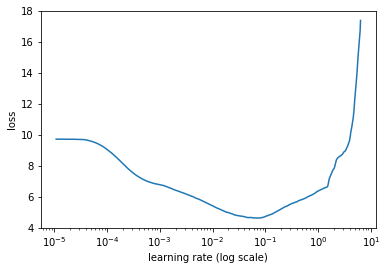

In [72]:
id_learner.sched.plot()

In [37]:
id_learner.fit(2.0e-2, 2, wds=1e-6, cycle_len=1, cycle_mult=3)

A Jupyter Widget

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1511320797808/work/torch/lib/THC/generic/THCStorage.cu:66

In [42]:
#del(id_learner)

In [ ]:
id_learner.save_encoder('adam1_enc')

# Process DataFrames and Create Data Loaders

In [15]:
def split_into_columns(x, split_by="/", ncol=4, fillna='NA'):
    l = str(x).split(split_by)
    return pd.Series((l+fillna*(ncol-len(l)))[:ncol])

In [16]:
test_df.head(2)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,<category> Women Jewelry Rings <name> Breast c...
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,<category> Other Officesupplies ShippingSuppli...


In [17]:
text_vars = ['item_description']
#text_var = []
cat_vars = ['item_condition_id', 'category_name', 'brand_name', 'shipping']
contin_vars = []
dep = 'price'

In [18]:
train_df2 = train[text_vars+cat_vars+contin_vars+[dep]].copy()
test_df[dep] = 0
test_df2 = test_df[text_vars+cat_vars+contin_vars+[dep, 'test_id']].copy()

Before we call torch text to create DataLoaders we need to convert categorical data to numerical data. 

In [19]:
# make train/test categories
for v in cat_vars: train_df2[v] = train_df2[v].astype('category').cat.as_ordered()
apply_cats(test_df2, train_df2)

In [20]:
cat_sz = [(c, len(train_df2[c].cat.categories)+1) for c in cat_vars]
cat_emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [21]:
# make float continuous variables if any
for v in contin_vars:
    train_df2[v] = train_df2[v].astype('float32')
    test_df2[v] = test_df2[v].astype('float32')

In [22]:
# numericalize all but the text field then add it back at the end
# pd.get_dummies creates expanded 1 hot encoding then collapsed
df, y, nas = proc_df(train_df2, dep, skip_flds=text_vars, do_scale=False)
df['item_description'] = train_df2['item_description']
df[dep] = np.log(y+1)

In [23]:
df_test, _, nas = proc_df(test_df2, dep, do_scale=False, 
                          skip_flds=text_vars + ['test_id'], na_dict=nas)
df_test['item_description'] = test_df2['item_description']
df_test[dep] = 0

In [24]:
display(df.head(2))
df_test.head(2)

,item_condition_id,category_name,brand_name,shipping,item_description,price
0,3,809,0,2,<category> Men Tops T-shirts <name> MLB Cincin...,2.397895
1,3,87,3558,1,<category> Electronics Computers&Tablets Compo...,3.970292


,item_condition_id,category_name,brand_name,shipping,item_description,price
0,1,1183,0,2,<category> Women Jewelry Rings <name> Breast c...,0
1,1,878,0,2,<category> Other Officesupplies ShippingSuppli...,0


#### call torch.text to process the text in text field and create data splits

In [25]:
class MixedTextDataset(torchtext.data.Dataset):
    def __init__(self, split_type, text_name, data_fields, dfs, **kwargs):
        type(self).text_name = text_name
        fields = list(data_fields.items())
        cols = [fld[0] for fld in fields]
        #cols.remove(text_name)
        df = dfs[split_type]
        
        examples = []
        for i,row in df.iterrows():
            examples.append(data.Example.fromlist(list(row[cols]), fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(getattr(ex, MixedTextDataset.text_name))
    
    @classmethod
    def splits(cls, data_fields, train, val, test, dfs, **kwargs):
        # set path to null ('') as we are dealing with dataframes
        return super().splits('', data_fields=data_fields,  
                              train=train, validation=val, test=test, dfs=dfs, **kwargs)

In [26]:
dfs = {'test': df_test}
(dfs['val'], dfs['train']),  = split_by_idx(val_idx, df)

In [27]:
min_freq=10

In [28]:
ITEM_DESCRIPTION = pickle.load(open(f'{PATH}models/ITEM_DESCRIPTION_{min_freq}.pkl','rb'))
# test my_spacy_token
my_spacy_tok(df['item_description'].iloc[0])

['<category>',
 'men',
 'tops',
 't',
 '-',
 'shirts',
 '<name>',
 'mlb',
 'cincinnati',
 'reds',
 't',
 'shirt',
 'size',
 'xl',
 '<description>',
 'no',
 'description',
 'yet']

In [29]:
DATA_FIELDS = {'item_description': ITEM_DESCRIPTION}
for v in cat_vars: 
    DATA_FIELDS[v] = data.Field(sequential=False, use_vocab=False)
DATA_FIELDS[dep] = data.Field(sequential=False, tensor_type=torch.FloatTensor, use_vocab=False)

In [30]:
# full set takes 25mins on 1060
splits = MixedTextDataset.splits(DATA_FIELDS, text_name='item_description', train='train', 
                                     val='val', test='test', dfs=dfs)

In [31]:
# Fields contain vocab, examples contain data 
splits[0].fields['price'], splits[0].examples[0].item_description

(<torchtext.data.field.Field at 0x7f8700dc4208>,
 ['<category>',
  'men',
  'tops',
  't',
  '-',
  'shirts',
  '<name>',
  'mlb',
  'cincinnati',
  'reds',
  't',
  'shirt',
  'size',
  'xl',
  '<description>',
  'no',
  'description',
  'yet'])

In [32]:
# minor changes to core.py to take list of lists 
def V_(x, requires_grad=False):
    return create_variable(x, False, requires_grad=requires_grad)
def V(x, requires_grad=False):
    return [V(o, requires_grad) for o in x] if isinstance(x,list) else V_(x, requires_grad)

def VV_(x): return create_variable(x, True)
def VV(x):  return [VV(o) for o in x] if isinstance(x,list) else VV_(x)

In [33]:
class MixedTextDataLoader():
    def __init__(self, src, x_fld, c_flds, y_fld):
        self.src,self.x_fld,self.c_flds, self.y_fld = src,x_fld,c_flds, y_fld

    def __len__(self): return len(self.src)-1

    def __iter__(self):
        it = iter(self.src)
        for i in range(len(self)):
            b = next(it)
            yield getattr(b, self.x_fld), [getattr(b, f) for f in self.c_flds], getattr(b, self.y_fld)


class MixedTextModel(BasicModel):
    def get_layer_groups(self):
        # defines how the differential learning rates would be applied to model groups
        m=self.model
        m_enc = m.rnn_encoder
        return [m_enc.encoder, *zip(m_enc.rnns, m_enc.dropouths), (children(m.lins)+children(m.bns)+[m.outp])]

class MixedTextData(ModelData):
    def create_td(self, it): return TextDataLoader(it, self.text_fld, self.label_fld)

    @classmethod
    def from_splits(cls, path, splits, bs, text_name='text', target_name='label', cat_names=['category']):
        text_fld = splits[0].fields[text_name]
        target_fld = splits[0].fields[target_name]
        if hasattr(target_fld, 'build_vocab') and target_fld.build_vocab == True: target_fld.build_vocab(splits[0])
        iters = torchtext.data.BucketIterator.splits(splits, batch_size=bs)
        trn_iter,val_iter,test_iter = iters[0],iters[1],None
        test_dl = None
        if len(iters) == 3:
            test_iter = iters[2]
            test_dl = MixedTextDataLoader(test_iter, text_name, cat_names, target_name)
        trn_dl = MixedTextDataLoader(trn_iter, text_name, cat_names, target_name)
        val_dl = MixedTextDataLoader(val_iter, text_name, cat_names, target_name)
        obj = cls.from_dls(path, trn_dl, val_dl, test_dl)
        obj.bs = bs
        obj.pad_idx = text_fld.vocab.stoi[text_fld.pad_token]
        obj.nt = len(text_fld.vocab)
        target_len = (target_fld.vocab if hasattr(target_fld, 'vocab')
                        else getattr(splits[0][0], target_name))
        try: 
            obj.c = len(target_len)
        except (TypeError):
            obj.c = None
            
        return obj


    def get_learner(self, opt_fn, text_emb_sz, enc_n_hid, enc_n_layers, enc_max_sl, enc_bptt, 
                    cat_emb_szs, cat_emb_drop, fc_layers, fc_drops, out_sz, y_range=None, use_bn=False, 
                    dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, **kwargs):
        
        rnn_enc = MultiBatchRNN(enc_max_sl, enc_bptt, self.bs, self.nt, text_emb_sz, enc_n_hid, 
                                enc_n_layers, pad_token=self.pad_idx, bidir=False, dropouth=dropouth, 
                                dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
        
        m = MixedTextInputModel(cat_emb_szs, 0, cat_emb_drop, out_sz, fc_layers, fc_drops, y_range, use_bn, text_emb_sz,
                            rnn_enc)
        
        model = MixedTextModel(to_gpu(m))
        return MixedTextLearner(self, model, opt_fn=opt_fn)

In [34]:
class MixedTextInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, text_emb_sz=0, rnn_encoder=None):
        super().__init__()
        
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        self.text_emb_sz, self.rnn_encoder = text_emb_sz, rnn_encoder
            
        szs = [n_emb+n_cont+3*text_emb_sz] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)
        
    def forward(self, x_text, x_cat, x_cont=None):

        if self.n_emb != 0:
            x = [e(x_cat[i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        
        if self.rnn_encoder:
            enc_raw_outputs, enc_outputs = self.rnn_encoder(x_text)
            enc_last_layer = enc_outputs[-1]
            sl,bs,_ = enc_last_layer.size()
            avgpool = self.pool(enc_last_layer, bs, False)
            mxpool = self.pool(enc_last_layer, bs, True)
            x3 = torch.cat([enc_last_layer[-1], mxpool, avgpool], 1)
            x = torch.cat([x, x3], 1)
            
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        
        # encoder outputs are needed by the regularization function
        return x, enc_raw_outputs, enc_outputs

    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()
    
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss
        
class MixedTextLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss
        # self.crit = F.cross_entropy

    def save_encoder(self, name): save_model(self.model.rnn_encoder, self.get_model_path(name))
    def load_encoder(self, name): load_model(self.model.rnn_encoder, self.get_model_path(name))

In [43]:
bs = 128

In [44]:
md = MixedTextData.from_splits(PATH, splits, bs, text_name=text_vars[0], target_name=dep, cat_names=cat_vars)

In [45]:
*xbs, yb = next(iter(md.trn_dl))

In [46]:
# same as to_np(xs[0])
xdf = pd.DataFrame(xbs[0].data.cpu().numpy())
xdf.apply(lambda x: x.apply(lambda x1: ITEM_DESCRIPTION.vocab.itos[x1]))

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,...,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>
1,women,electronics,women,women,handmade,kids,beauty,home,kids,beauty,...,women,handmade,kids,men,kids,beauty,women,home,women,kids
2,underwear,<unk>,sweaters,sweaters,<unk>,boys,makeup,<unk>,toys,fragrance,...,<unk>,<unk>,toys,<unk>,toys,makeup,<unk>,<unk>,sweaters,toys
3,bras,<unk>,<unk>,crewneck,tote,0,nails,cor,<unk>,women,...,<unk>,sticker,puzzles,flight,<unk>,lips,jackets,<unk>,crewneck,<unk>
4,<name>,<name>,<name>,<name>,<name>,-,<name>,<unk>,<name>,<name>,...,<name>,<name>,<name>,bomber,<name>,<name>,<name>,<name>,<name>,<name>
5,victoria,teal,lularoe,f,michael,2,jamberry,<name>,paw,dolce,...,aeropostale,4,flag,<name>,slime,lip,adidas,new,virginia,alexander
6,'s,mushroom,large,2,kors,4,wrap,ruby,patrol,&,...,black,0,fidget,a&f,collection,lot,jacket,scentportables,tech,baby
7,secret,bluetooth,arrow,1,medium,mos,bundle,red,party,gabbana,...,huge,thank,spinner,all,7,<description>,<description>,for,university,<unk>
8,pink,speaker,sarah,fur,tote,one,for,3,supplies,light,...,tote,you,<description>,season,colors,nyx,never,your,crewneck,shipping
9,bra,<description>,<description>,sweater,<description>,-,joanna,headed,<description>,blue,...,<description>,stickers,one,weather,!,jumbo,worn,car,<description>,)


In [47]:
bptt, max_sl=50, 200
text_emb_sz = 100  # size of each embedding vector
enc_n_hid = 200     # number of hidden activations per layer
enc_n_layers = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
cat_emb_drop=0.04
fc_layers=[1000, 500]
fc_drops =[0.001, 0.01]

In [48]:
y_range = (np.min(np.log(y+1)), np.max(np.log(y+1)))
y_range

(0.0, 7.6058900010531216)

In [49]:
learner = md.get_learner(opt_fn, text_emb_sz, enc_n_hid, enc_n_layers, max_sl, bptt, 
                    cat_emb_szs, cat_emb_drop, fc_layers, fc_drops, out_sz=1, y_range=y_range, 
                    dropouti=0.65, dropoute=0.1, dropouth=0.3, wdrop=0.5)

learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=3.0

In [50]:
learner.load_encoder(f'adam1_enc')

While copying the parameter named encoder.weight, whose dimensions in the model are torch.Size([20792, 100]) and whose dimensions in the checkpoint are torch.Size([17013, 100]), ...


RuntimeError: invalid argument 2: sizes do not match at /opt/conda/conda-bld/pytorch_1511320797808/work/torch/lib/THC/generic/THCTensorCopy.c:48

In [51]:
len(ITEM_DESCRIPTION.vocab.itos[:])

20792

In [67]:
#lrs=np.array([1e-4,1e-3,1e-2])

Lets test if the model is correctly defined as data is being correctly processed. 

In [69]:
m = learner.model
#m.rnn_encoder(*[xs[0]])
m.reset()
output = m(*xbs)

In [70]:
output

(Variable containing:
  3.6181
  3.9446
  3.7202
  3.6678
  3.8783
  3.7263
  3.9661
  3.4908
  3.8354
  3.8559
  3.8013
  3.3799
  3.6042
  3.9475
  3.8356
  3.8966
  3.5658
  3.7949
  3.5020
  3.6923
  4.2151
  3.5769
  3.4816
  3.8391
  3.3249
  3.5473
  3.7893
  3.5662
  3.7217
  3.8910
  3.4415
  3.3827
  3.2523
  3.8972
  3.3478
  3.7975
  3.5294
  3.6582
  3.6804
  3.7621
  3.2584
  3.8015
  3.6557
  3.6046
  4.1807
  3.3565
  3.6747
  3.7143
  3.8558
  3.7824
  4.4163
  3.7560
  3.6889
  3.6515
  3.8735
  3.7477
  3.8140
  3.4001
  3.8260
  3.5541
  3.5676
  3.3578
  3.5410
  3.5185
  3.7121
  3.7429
  3.7495
  3.6752
  3.9159
  3.6501
  3.6887
  3.4351
  3.6867
  3.8932
  3.5829
  3.9509
  3.6481
  3.6799
  3.9697
  3.6319
  3.3755
  3.9984
  3.6916
  3.8138
  3.6280
  3.7956
  3.7160
  3.5720
  3.8919
  3.8289
  3.6233
  3.6392
  3.6914
  3.4172
  3.7554
  3.5829
  3.4342
  3.7841
  3.4219
  3.2321
  3.6565
  3.8305
  3.6280
  3.6028
  3.5750
  3.5899
  3.7033
  3.4524
  3.46

In [71]:
learner.lr_find()

A Jupyter Widget

 65%|██████▍   | 1199/1853 [01:00<00:32, 19.97it/s, loss=1.81] 

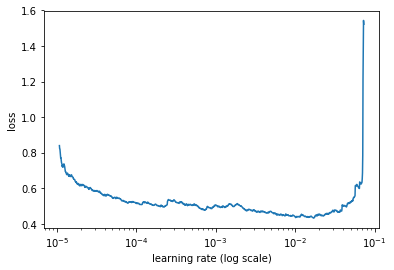

In [72]:
learner.sched.plot()

In [73]:
lrs=np.array([1e-4,1e-3,1e-2])
learner.freeze_to(-1)
learner.fit(lrs/2, 1)
learner.unfreeze()
learner.fit(lrs, 1, cycle_len=1)

A Jupyter Widget

 10%|█         | 190/1853 [00:03<00:30, 54.58it/s, loss=1.07]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/deb/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/deb/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/deb/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.03309  0.93178]                                  



A Jupyter Widget

[ 0.       0.48971  0.42335]                                   



In [74]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='mercari')

A Jupyter Widget

[ 0.       0.48497  0.40723]                                   
[ 1.       0.4582   0.39291]                                   
[ 2.       0.46481  0.38959]                                   
[ 3.       0.4628   0.37633]                                   
[ 4.       0.41846  0.37075]                                   
[ 5.       0.4405   0.36309]                                   
[ 6.       0.4339   0.36285]                                   



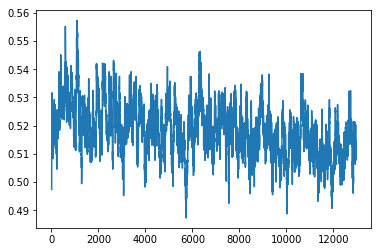

In [187]:
learner.sched.plot_loss()

# Learner and Model

In [24]:
dep = 'price'
test[dep] = 0
joined = train[cat_vars+contin_vars+[dep,'name']].copy()
joined_test = test[cat_vars+contin_vars+[dep, 'name',  'test_id']].copy()

In [25]:
cat_vars+contin_vars+[dep,'name']

['cat1',
 'cat2',
 'cat3',
 'brand_name',
 'shipping',
 'item_condition_id',
 'price',
 'name']

In [26]:
######## NYI
# factors the individual columns (does not make sense for item_description need NLP??)
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [27]:
apply_cats(joined_test, joined)

In [28]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [29]:
#joined['item_condition_id'] = joined.item_condition_id.astype(np.int32)
#joined['shipping'] = joined.shipping.astype(np.int32)
#joined_test['item_condition_id'] = joined_test.item_condition_id.astype(np.int32)
#joined_test['shipping'] = joined_test.shipping.astype(np.int32)

In [30]:
n = len(joined)
idxs = get_cv_idxs(n, val_pct=0.2)
joined_samp = joined.iloc[idxs].set_index("name")
samp_size = len(joined_samp); samp_size

296507

In [31]:
#n = len(joined)
#samp_size = n
#joined_samp = joined

In [32]:
joined_samp.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id,price
name,,,,,,,
F/ship 4 Totoro Washi + 1 pen,Handmade,Paper Goods,Stationery,NaN,1,1.0,12.0
UCLA Men's Bundle + Shorts,Women,Other,Other,Adidas,1,1.0,76.0
Listing for lol,Beauty,Makeup,Lips,NaN,1,1.0,12.0
25 pcs kawaii sticker flakes,Kids,Toys,Arts & Crafts,NaN,1,1.0,3.0
Chanel Mini Lipgloss Set,Beauty,Makeup,Lips,Chanel,1,2.0,30.0


In [33]:
#??proc_df

In [34]:
len(joined_samp)

296507

In [35]:
joined_test = joined_test

In [36]:
joined_test = joined_test.set_index("name")
joined = joined.set_index("name")

In [37]:
df, y, nas, mapper = proc_df(joined, 'price', do_scale=True)
yl = np.log(y+1).astype('float32')

In [38]:
df_test, _, nas, mapper = proc_df(joined_test, 'price', do_scale=True, skip_flds=['test_id'],
                                  mapper=mapper, na_dict=nas)
#for n,c in joined_samp.items(): print(n), print(c)

In [39]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [40]:
val_idx[1:5]

[222381, 222382, 222383, 222384]

In [41]:
df.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id
name,,,,,,
MLB Cincinnati Reds T Shirt Size XL,6,104,764,0,2,1.209777
Razer BlackWidow Chroma Keyboard,2,31,213,3558,1,1.209777
AVA-VIV Blouse,10,105,95,4181,2,-1.004675
Leather Horse Statues,4,56,405,0,2,-1.004675
24K GOLD plated rose,10,59,538,0,1,-1.004675


In [42]:
len(joined)

1482535

In [43]:
def exp_rmsle(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [44]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

In [45]:
yl.dtype

dtype('float32')

In [46]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [47]:
cat_sz

[('cat1', 12),
 ('cat2', 115),
 ('cat3', 872),
 ('brand_name', 4810),
 ('shipping', 3)]

In [48]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [49]:
emb_szs

[(12, 6), (115, 50), (872, 50), (4810, 50), (3, 2)]

In [50]:
df.columns

Index(['cat1', 'cat2', 'cat3', 'brand_name', 'shipping', 'item_condition_id'], dtype='object')

In [51]:
cat_vars

['cat1', 'cat2', 'cat3', 'brand_name', 'shipping']

In [52]:
y_range

(0, 9.1270677566528313)

In [53]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1500,1000,500], [0.001,0.01,0.01], y_range=y_range)
lr = 1e-3

In [54]:
m.lr_find()

A Jupyter Widget

 61%|██████▏   | 1068/1738 [00:09<00:05, 114.63it/s, loss=1.72] 


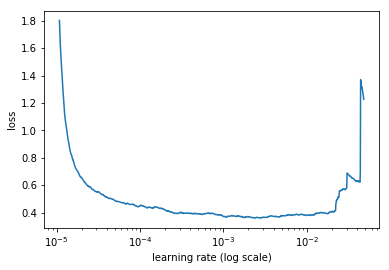

In [55]:
m.sched.plot()

In [56]:
lr=5.0e-5
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.36065  0.35247  0.59251]                           
[ 1.       0.334    0.32686  0.57049]                           
[ 2.       0.3201   0.32173  0.56601]                           
[ 3.       0.31909  0.32209  0.56627]                           
[ 4.       0.31596  0.31786  0.56258]                           
[ 5.       0.29835  0.31438  0.55947]                           
[ 6.       0.30538  0.31377  0.55894]                           



In [48]:
lr = 5.0e-4
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=2)

A Jupyter Widget

[ 0.       0.32404  0.31878  0.56345]                           
[ 1.       0.30513  0.31197  0.55732]                           
[ 2.       0.29919  0.31445  0.55954]                           
[ 3.       0.28376  0.31089  0.55636]                           
[ 4.       0.30098  0.3125   0.55779]                           
[ 5.       0.28833  0.31059  0.55608]                           



In [47]:
??md.get_learner